In [78]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

In [79]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    "Converts floating number to 8bit images, returns image."
    
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [80]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = int(len(files)) # Loading all images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])


Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png


Image size = 400,400


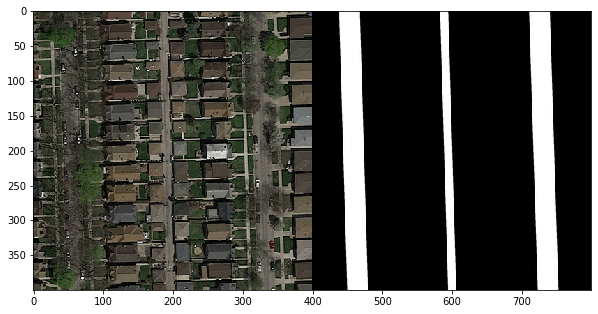

In [86]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [87]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [88]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X

In [89]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [90]:
print(X.shape)
print(Y.shape)

(62500, 2)
(62500,)


# Neural Network Implementation

Loading Tensorflow library

In [81]:
import numpy as np
import tensorflow as tf
from tensorflow.python import keras

CONVERSION OF DATA TO NUMPY ARRAYS

In [91]:
x_train = X
y_train = tf.keras.utils.to_categorical(np.array(Y))

print('x_train has a shape of',x_train.shape)
print('y_train has a shape of',y_train.shape)

x_train has a shape of (62500, 2)
y_train has a shape of (62500, 2)


INITIALIZATION OF LAYERS WITH RESPECTIVE NUMBER OF NODES AND ACTIVATION FUNCTIONS

In [183]:
#FEEDFORWARD NETWORK
model = tf.keras.Sequential()

#INPUT LAYER SHAPE
input_shape = (x_train.shape[1],)

#HIDDEN LAYER PARAMETERS
nodes = [100,100,100,100,100,100,100,100,100,100]
activations = ['sigmoid','sigmoid','sigmoid','sigmoid','sigmoid','sigmoid','sigmoid','sigmoid','sigmoid','sigmoid']

#FULLY-CONNECTED (Dense) HIDDEN LAYER(S)
model.add(tf.keras.layers.Dense(nodes[0],activation = activations[0],input_shape = (x_train.shape[1],)))
for node, activation_function in zip(nodes[1:],activations[1:]):
    model.add(tf.keras.layers.Dense(node,activation = activation_function))

#FULLY-CONNECTED OUTPUT LAYER
model.add(tf.keras.layers.Dense(2,activation = 'softmax'))


INITIALIZATION OF OPTIMIZATION METHOD, LOSS FUNCTION AND METRIC

In [184]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

TRAINING OVER DATA

In [185]:
model.fit(x_train,y_train,validation_split=0.2, epochs=10,verbose = 2)

Train on 50000 samples, validate on 12500 samples
Epoch 1/10
50000/50000 - 6s - loss: 0.5737 - accuracy: 0.7425 - val_loss: 0.5849 - val_accuracy: 0.7309
Epoch 2/10
50000/50000 - 5s - loss: 0.5716 - accuracy: 0.7435 - val_loss: 0.5827 - val_accuracy: 0.7309
Epoch 3/10
50000/50000 - 6s - loss: 0.5716 - accuracy: 0.7435 - val_loss: 0.5861 - val_accuracy: 0.7309
Epoch 4/10
50000/50000 - 6s - loss: 0.5716 - accuracy: 0.7435 - val_loss: 0.5856 - val_accuracy: 0.7309
Epoch 5/10
50000/50000 - 6s - loss: 0.5712 - accuracy: 0.7435 - val_loss: 0.5829 - val_accuracy: 0.7309
Epoch 6/10
50000/50000 - 6s - loss: 0.5708 - accuracy: 0.7435 - val_loss: 0.5827 - val_accuracy: 0.7309
Epoch 7/10
50000/50000 - 6s - loss: 0.5707 - accuracy: 0.7435 - val_loss: 0.5833 - val_accuracy: 0.7309
Epoch 8/10
50000/50000 - 6s - loss: 0.5705 - accuracy: 0.7435 - val_loss: 0.5840 - val_accuracy: 0.7309
Epoch 9/10
50000/50000 - 6s - loss: 0.5704 - accuracy: 0.7435 - val_loss: 0.5921 - val_accuracy: 0.7309
Epoch 10/10
50

PREDICTIONS

In [ ]:
y_pred = model.predict(x_test)